In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import os
import scipy.stats as sts
import pandas as pd

for gpu in tf.config.experimental.list_physical_devices('GPU'):
      tf.config.experimental.set_memory_growth(gpu, True)

import sys
import pickle
from matplotlib import pyplot as plt
sys.path.append('./../packages')
data_path = "../data/"
post_path = "../data/"
from utility import uniquify, reg_log

from feat_extractor import feature_extract, post_extract 
from hunt import  mgg, bphunt

# just figure plotting parameters
from style import le_size, la_size, ti_size, majt_size, mint_size, colormap, color_list, mfixed_labs, figwidth

2024-07-30 14:49:12.076041: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 14:49:12.293793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 14:49:12.951998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-30 14:49:15.457499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

### Features check and plot

Here we just import and look at the features

In [2]:
nobs = 2 # do not change
mfixed = 1.
smear = 0

if smear == 0:
    sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small uncertainty case
elif smear == 1:
    sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large" # large uncertainty case

nbkgmax = 5
nsigmax = 8
malp_min, malp_max = 0.1, 4.5
tmalp_min, tmalp_max = 0.05, 500 # SHiP
z_min, z_max, z_cal, l_x, l_y= 32, 82, 93, 2, 3 # SHiP
x_min, x_max = -l_x, l_x
y_min, y_max = -l_y, l_y

par_lab = "m_"+str(malp_min)+"_"+str(malp_max)+"_tm_"+str(tmalp_min)+"_"+str(tmalp_max)+"_"
geo_lab = "c_"+str(z_min)+"_"+str(z_max)+"_"+str(l_x)+"_"+str(l_y)


#### variable plots (truth level)

In [3]:
# sigs set to 0 for truth level
Ens = []
for mfixed in [0.2,1., 4.]:
    sigfile = data_path + "event_sig_8_m_"+str(mfixed)+"_"+str(mfixed)+"_tm_"+str(1.)+"_"+str(1.)+"_"+geo_lab+".csv"
    np.random.seed(42)
    feats=feature_extract(sigfile, 0,0, 0,0, Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max) #truth level
    Ens.append(np.stack(([feats.extract_llo(iobs)[0] for iobs in range(8)])).flatten())
Ens=np.array(Ens)

In [4]:
# sigs set to 0 for truth level
angles = []
for mfixed in [0.2,1., 4.]:
    sigfile = data_path+"event_sig_8_m_"+str(mfixed)+"_"+str(mfixed)+"_tm_"+str(1.)+"_"+str(1.)+"_"+geo_lab+".csv"

    df = pd.read_csv(sigfile)
    p1vec = np.vstack(([np.hstack(([df["px1_"+str(iobs)] for iobs in range(8)])),np.hstack(([df["py1_"+str(iobs)]for iobs in range(8)])), np.hstack(([df["pz1_"+str(iobs)]for iobs in range(8)]))])) 
    p2vec = np.vstack(([np.hstack(([df["px2_"+str(iobs)] for iobs in range(8)])),np.hstack(([df["py2_"+str(iobs)]for iobs in range(8)])), np.hstack(([df["pz2_"+str(iobs)]for iobs in range(8)]))])) 
    p1 = np.sqrt(np.sum(p1vec**2, axis=0))
    p2 = np.sqrt(np.sum(p2vec**2, axis=0))
    angles.append(np.log(np.arccos(np.sum(p1vec*p2vec, axis=0)/(p1*p2))))
angles = np.array(angles)

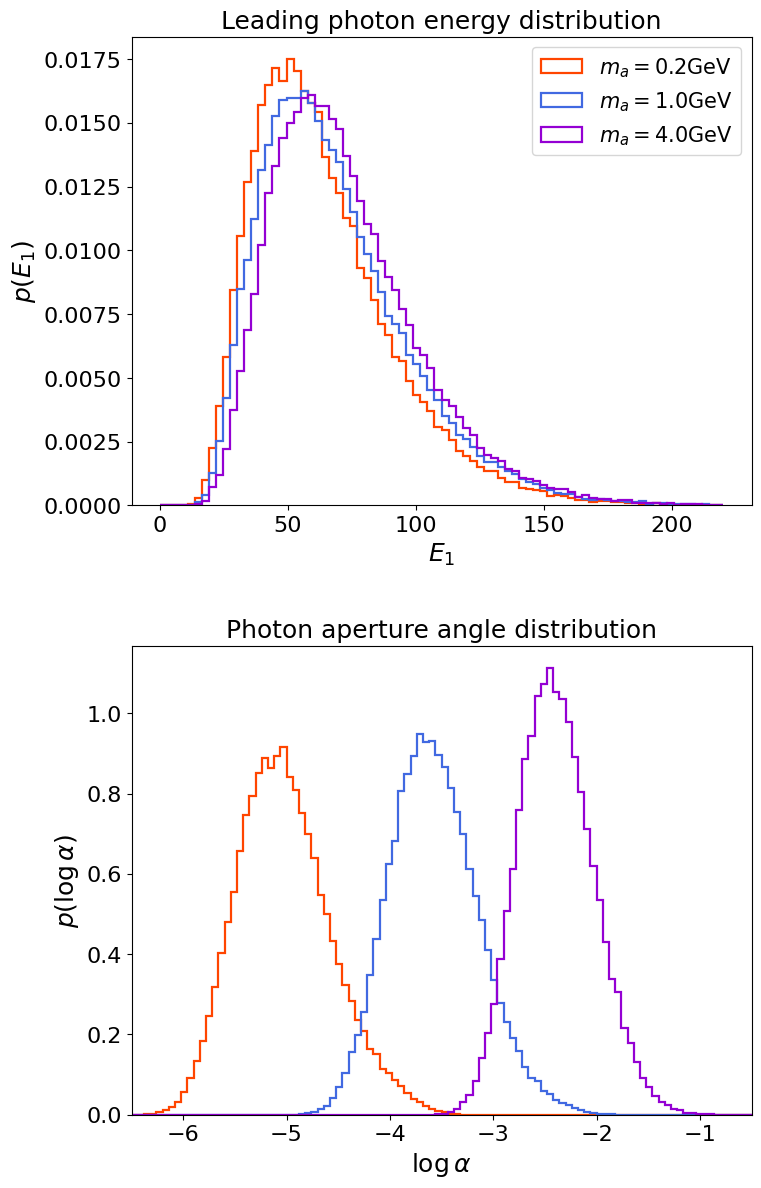

In [5]:
fig, axs = plt.subplots(nrows =2, figsize = (figwidth/2, 14), gridspec_kw={"hspace": 0.3})

for icol in range(3):
    axs[0].hist(np.exp(Ens[icol]), range=[0,220], bins=80, histtype='step', label=mfixed_labs[icol], linewidth=1.6, color=color_list[icol], density=True)
    axs[1].hist(angles[icol], range=[-6.5,-0.5], bins=100, histtype='step', label=mfixed_labs[icol], linewidth=1.6, color=color_list[icol], density=True)

axs[0].legend(fontsize=le_size)
axs[0].set_xlabel(r"$E_1$", fontsize=la_size)
axs[0].set_ylabel(r"$p(E_1$)", fontsize=la_size)


axs[1].set_xlim(-6.5,-0.5)
axs[1].set_xlabel(r"$\log \alpha$", fontsize=la_size)
axs[1].set_ylabel(r"$p(\log \alpha$)", fontsize=la_size)


for _ in range(2):
    axs[_].tick_params(axis='both', which='major', labelsize=majt_size)
    axs[_].tick_params(axis='both', which='minor', labelsize=mint_size)

axs[0].set_title("Leading photon energy distribution", fontsize=ti_size)
axs[1].set_title("Photon aperture angle distribution", fontsize=ti_size)
# plt.savefig("figures/variables.pdf", bbox_inches='tight')
plt.show()


## ROC curves together (performances already exported)

In [6]:
smear = 0

if smear == 0:
    sigs, labsm, labfig  = [0.001,0.01,0.005, 0.005 ], "small", "good" # small uncertainty case
elif smear == 1:
    sigs, labsm, labfig = [0.001,0.05,0.01,  0.01  ],  "large", "poor" # large uncertainty case

In [7]:
# import rocs for bins
bin_perfs_sep = np.loadtxt("../performances/roc/fprtpr_bin_sep.csv", skiprows=1)
bin_perfs_over = np.loadtxt("../performances/roc/fprtpr_bin_over.csv", skiprows=1)

Now we plot with different models at once

In [8]:
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D

/tmp/ipykernel_36932/619985919.py:19: RuntimeWarning: divide by zero encountered in divide
  inters.append(interp1d(tpr, 1/fpr))
/tmp/ipykernel_36932/619985919.py:27: RuntimeWarning: divide by zero encountered in divide
  inters.append(interp1d(tpr, 1/fpr))


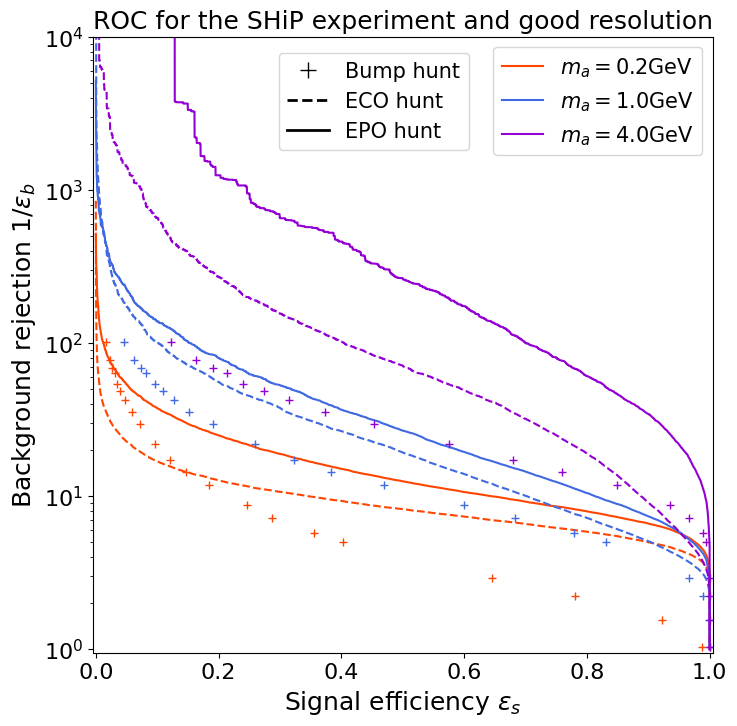

In [9]:
xlin = np.linspace(0, 1., 10000)

fig, axs = plt.subplots(figsize=(figwidth/2,figwidth/2))

custom_lines = [Line2D([0], [0], color='black', marker='+', lw=0, markersize=12),
                Line2D([0], [0], color='black', lw=2, linestyle='--'),
                Line2D([0], [0], color='black', lw=2)]

axs.add_artist(axs.legend(custom_lines, ["Bump hunt", "ECO hunt", "EPO hunt"], fontsize=le_size, loc=(0.3,0.816)))

for iC, mfixed in enumerate([0.2, 1., 4.]):
    #bin_perfs_sep_sel = bin_perfs_sep[(bin_perfs_sep[:,0]==smear)*(bin_perfs_sep[:,1]==mfixed)]
    bin_perfs_over_sel = bin_perfs_over[(bin_perfs_over[:,0]==smear)*(bin_perfs_over[:,1]==mfixed)]
    plt.plot(bin_perfs_over_sel[:,4], 1/bin_perfs_over_sel[:,3], marker='+', linestyle='', color=color_list[iC])

    inters = []
    for imodel in range(5):
        fpr, tpr, _ = np.loadtxt("../performances/roc/fprtpr_cl_obs_"+labsm+"_m_"+str(mfixed)+"_model"+str(imodel)+".csv").T
        inters.append(interp1d(tpr, 1/fpr))
    vals = np.array([inters[imodel](xlin) for imodel in range(5)])
    vals[vals==np.inf]=10**5 #regularization for plot
    # plt.fill_between(xlin, np.min(vals,axis=0), np.max(vals,axis=0), alpha=0.8, color='none', edgecolor=color_list[iC], linestyle='', hatch='+')
    plt.plot(xlin, np.mean(vals,axis=0), color=color_list[iC], linestyle='--')
    inters = []
    for imodel in range(5):
        fpr, tpr, _ = np.loadtxt("../performances/roc/fprtpr_cl_post_"+labsm+"_m_"+str(mfixed)+"_model"+str(imodel)+".csv").T
        inters.append(interp1d(tpr, 1/fpr))
    vals = np.array([inters[imodel](xlin) for imodel in range(5)])
    vals[vals==np.inf]=10**5 #regularization for plot
    # plt.fill_between(xlin, np.min(vals,axis=0), np.max(vals,axis=0),  alpha=0.25, color=color_list[iC], linestyle='', linewidth=0.0)
    plt.plot(xlin, np.mean(vals,axis=0), color=color_list[iC], label=mfixed_labs[iC])
plt.yscale('log')
plt.legend(fontsize= le_size)
# plt.axhline(5.23)
# plt.axhline(5.39)
# plt.axhline(20.7)



axs.legend(fontsize=le_size)
axs.set_xlabel(r"Signal efficiency $\epsilon_s$", fontsize=la_size)
axs.set_ylabel(r"Background rejection $1/\epsilon_b$", fontsize=la_size)
axs.set_title("ROC for the SHiP experiment and "+labfig+" resolution", fontsize=ti_size)
axs.set_xlim(-0.005,1.005)
axs.set_ylim(0.95,10**4)
axs.set_yscale('log')




axs.tick_params(axis='both', which='major', labelsize=majt_size)
axs.tick_params(axis='both', which='minor', labelsize=mint_size)


plt.savefig("../figures/rocv_mean_"+labfig+".pdf", bbox_inches='tight')

plt.show()


## bumphunt $m_{\gamma\gamma}$ (ROC)

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

In [11]:
smear = 0 

if smear == 0:
    sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small uncertainty case
elif smear == 1:
    sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large" # large uncertainty case

malp_min, malp_max = 0.1, 4.5
tmalp_min, tmalp_max = 0.05, 500 # SHiP
z_min, z_max, z_cal, l_x, l_y= 32, 82, 93, 2, 3 # SHiP

x_min, x_max = -l_x, l_x
y_min, y_max = -l_y, l_y

par_lab = "m_"+str(malp_min)+"_"+str(malp_max)+"_tm_"+str(tmalp_min)+"_"+str(tmalp_max)+"_"
geo_lab = "c_"+str(z_min)+"_"+str(z_max)+"_"+str(l_x)+"_"+str(l_y)


In [13]:
# fixed mass, separately for separated bins and overlapping bins (since binning values should be adapted)

bin_over = 3

bin_perfs_sep = []
bin_perfs_over = []

for mfixed in [0.2, 1., 4.]:
    sigfile = data_path+"event_sig_8_m_"+str(mfixed)+"_"+str(mfixed)+"_tm_"+str(1.)+"_"+str(1.)+"_"+geo_lab+".csv"
    bkgfile = data_path+"event_bkg_13_"+par_lab+geo_lab+".csv"
    for smear in [0, 1]:

        if smear ==0:
            sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small smearing case
        elif smear == 1:
            sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large"


        nbkg = 2 
        nsig = 0
        nobs = nbkg+nsig

        np.random.seed(42)
        feats=feature_extract(bkgfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
        features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nbkg)]))  
        x0 = features.T

        # very specific signal, 1 GeV
        nbkg = 0 
        nsig = 2
        nobs = nbkg+nsig

        np.random.seed(42)
        feats=feature_extract(sigfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
        features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nsig)]))  
        x1 = features.T

        X = np.vstack((x0,x1))
        y=np.hstack((np.zeros(len(x0)),np.ones(len(x1))))

        mggX = mgg(X)

        for nbins in [2, 3, 4, 5, 7, 8, 10, 12, 15, 20, 25, 30, 35, 40, 50, 60,  80,  100, 150, 200]:
            bin_counting = bphunt(np.log10(mggX), nbins, [-1.5, 0.8]).counting()
            # bin_counting_over = sum([bin_counting[1+i:nbins-bin_over+i+1] for i in range(bin_over)])
            prediction = bin_counting.max(0)>1 # binary so at most 2
            fpr, tpr, _ = roc_curve(y, prediction)
            bin_perfs_sep.append([smear, mfixed, nbins, fpr[1], tpr[1]])

        for nbins in [5, 10, 15, 20, 35, 40, 50, 60, 80, 100, 120, 150, 200, 250, 300, 350,  400, 450, 500, 600, 800]:
            bin_counting = bphunt(np.log10(mggX), nbins, [-1.5, 0.8]).counting()
            bin_counting_over = sum([bin_counting[1+i:nbins-bin_over+i+1] for i in range(bin_over)])
            prediction = bin_counting_over.max(0)>1 # binary so at most 2
            fpr, tpr, _ = roc_curve(y, prediction)
            bin_perfs_over.append([smear, mfixed, nbins, fpr[1], tpr[1], bin_over])

bin_perfs_sep = np.array(bin_perfs_sep)
bin_perfs_over = np.array(bin_perfs_over)

In [14]:
# choose specific mass and smear just to see if it works
bin_perfs_sep_sel = bin_perfs_sep[(bin_perfs_sep[:,0]==1) * (bin_perfs_sep[:,1]==1.)]
bin_perfs_over_sel = bin_perfs_over[(bin_perfs_over[:,0]==1) * (bin_perfs_over[:,1]==1.)]

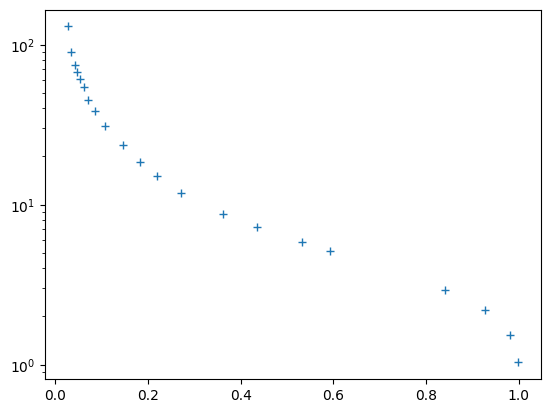

In [15]:
plt.plot(bin_perfs_over_sel[:,4], 1/bin_perfs_over_sel[:,3], marker='+', linestyle='')
plt.yscale('log')
plt.show()

In [14]:
# np.savetxt("../performances/roc/fprtpr_bin_sep.csv", bin_perfs_sep,  header = "smearing, mass, nbins, fpr, tpr")
# np.savetxt("../performances/roc/fprtpr_bin_over.csv", bin_perfs_over,  header = "smearing, mass, nbins, fpr, tpr, overlapping")

## ECO hunt(ROC)

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

In [17]:
smear = 0

if smear == 0:
    sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small uncertainty case
elif smear == 1:
    sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large" # large uncertainty case

malp_min, malp_max = 0.1, 4.5
tmalp_min, tmalp_max = 0.05, 500 # SHiP
z_min, z_max, z_cal, l_x, l_y= 32, 82, 93, 2, 3 # SHiP

x_min, x_max = -l_x, l_x
y_min, y_max = -l_y, l_y

par_lab = "m_"+str(malp_min)+"_"+str(malp_max)+"_tm_"+str(tmalp_min)+"_"+str(tmalp_max)+"_"
geo_lab = "c_"+str(z_min)+"_"+str(z_max)+"_"+str(l_x)+"_"+str(l_y)


In [18]:
dirfolder ="../models/model_01_"+labsm+"_0"
# model = keras.models.load_model(dirfolder+"/model.keras")
model = keras.models.load_model(dirfolder+"/model.tf")
print(dirfolder)

2024-07-30 14:50:06.051498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 14:50:06.051735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 14:50:06.051859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

../models/model_01_small_0


In [19]:
with open(dirfolder+'/meta_par.pkl', 'rb') as file_t:
   meta_par = pickle.load(file_t)

#### ROC curve

/home/alessandro/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_36932/2309013464.py:52: RuntimeWarning: divide by zero encountered in divide
  axs.plot(tpr, 1/fpr, label = r"$m_a=$"+"{:.1f}GeV, AUC={:.2f}".format(mfixed, roc_auc_score(y, scores)), color=color_list[icol], linewidth = 1.5)
/home/alessandro/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persist

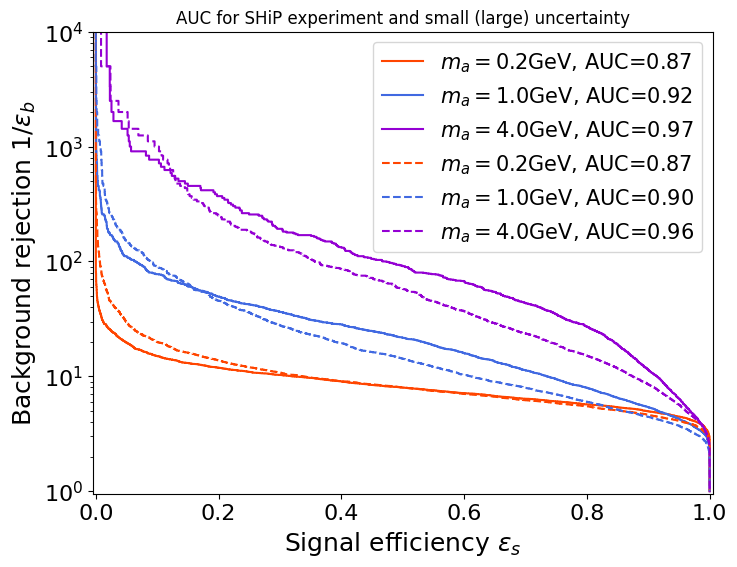

In [22]:
# plot roc curve for a fixed ML model
# choose fixed mass here

fig, axs = plt.subplots(figsize = (8, 6))
efficiencies = []
for smear in [0, 1]:
    if smear ==0:
        sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small smearing case
    elif smear == 1:
        sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large"

    dirfolder ="../models/model_01_"+labsm+"_0" # or _0
    model = keras.models.load_model(dirfolder+"/model.tf")

    for icol, mfixed in enumerate([0.2, 1., 4.]):
        sigfile = data_path+"event_sig_8_m_"+str(mfixed)+"_"+str(mfixed)+"_tm_"+str(1.)+"_"+str(1.)+"_"+geo_lab+".csv"
        bkgfile = data_path+"event_bkg_13_"+par_lab+geo_lab+".csv"

        nbkg = 2 
        nsig = 0
        nobs = nbkg+nsig

        np.random.seed(42)
        feats=feature_extract(bkgfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
        features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nbkg)]))  
        x0 = features.T

        # very specific signal, 1 GeV
        nbkg = 0 
        nsig = 2
        nobs = nbkg+nsig

        np.random.seed(42)
        feats=feature_extract(sigfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
        features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nsig)]))  
        x1 = features.T


        X = np.vstack((x0,x1))
        y=np.hstack((np.zeros(len(x0)),np.ones(len(x1))))

        xzscaler = pickle.load(open(dirfolder+'/xzscaler.pkl', 'rb'))
        X = xzscaler.transform(X)

        del x0, x1, feats, features

        scores = np.array(model(X)).flatten()


        fpr, tpr, thr_list = roc_curve(y, scores)
        if smear == 0:
            axs.plot(tpr, 1/fpr, label = r"$m_a=$"+"{:.1f}GeV, AUC={:.2f}".format(mfixed, roc_auc_score(y, scores)), color=color_list[icol], linewidth = 1.5)
        elif smear == 1:
            axs.plot(tpr, 1/fpr, label = r"$m_a=$"+"{:.1f}GeV, AUC={:.2f}".format(mfixed, roc_auc_score(y, scores)), color=color_list[icol], linewidth = 1.5, linestyle='--')
        efficiencies.append([smear, mfixed, tpr[fpr>0.1][0],tpr[fpr>0.01][0], 1/fpr[tpr>0.8][0], 1/fpr[tpr>0.9][0]])


axs.legend(fontsize=le_size)
axs.set_xlabel(r"Signal efficiency $\epsilon_s$", fontsize=la_size)
axs.set_ylabel(r"Background rejection $1/\epsilon_b$", fontsize=la_size)
axs.set_title("AUC for SHiP experiment and small (large) uncertainty")
axs.set_xlim(-0.005,1.005)
axs.set_ylim(0.95,10**4)
axs.set_yscale('log')

axs.tick_params(axis='both', which='major', labelsize=majt_size)
axs.tick_params(axis='both', which='minor', labelsize=mint_size)


# plt.savefig("figures/roc.pdf", bbox_inches='tight')
plt.show()

Now we actually save the performances separately for different models (so to evaluate the network uncertainties)

In [23]:
for imodel in range(5):
    efficiencies = []
    for smear in [0, 1]:
        if smear ==0:
            sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small smearing case
        elif smear == 1:
            sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large"

        dirfolder = "../models/model_01_"+labsm+"_"+str(imodel)
        model = keras.models.load_model(dirfolder+"/model.tf")

        for mfixed in[0.2, 1., 4.]:
            sigfile = data_path+"event_sig_8_m_"+str(mfixed)+"_"+str(mfixed)+"_tm_"+str(1.)+"_"+str(1.)+"_"+geo_lab+".csv"
            bkgfile = data_path+"event_bkg_13_"+par_lab+geo_lab+".csv"

            nbkg = 2 
            nsig = 0
            nobs = nbkg+nsig

            np.random.seed(42)
            feats=feature_extract(bkgfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nbkg)]))  
            x0 = features.T

            # very specific signal, 1 GeV
            nbkg = 0 
            nsig = 2
            nobs = nbkg+nsig

            np.random.seed(42)
            feats=feature_extract(sigfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nsig)]))  
            x1 = features.T


            X = np.vstack((x0,x1))
            y=np.hstack((np.zeros(len(x0)),np.ones(len(x1))))

            xzscaler = pickle.load(open(dirfolder+'/xzscaler.pkl', 'rb'))
            X = xzscaler.transform(X)

            del x0, x1, feats, features

            scores = np.array(model(X)).flatten()


            fpr, tpr, thr_list = roc_curve(y, scores)
            efficiencies.append([smear, mfixed, tpr[fpr>0.1][0],tpr[fpr>0.01][0], 1/fpr[tpr>0.8][0], 1/fpr[tpr>0.9][0], roc_auc_score(y, scores)])
            # np.savetxt("../performances/roc/fprtpr_cl_obs_"+labsm+"_m_"+str(mfixed)+"_model"+str(imodel)+".csv", np.vstack((fpr, tpr, thr_list)).T)
        # np.savetxt("../performances/roc/roc_efficiencies_obs_model"+str(imodel)+".csv", np.array(efficiencies))

/home/alessandro/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alessandro/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alessandro/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when 

## posterior reconstruction and extraction

### reconstruction (includes coverage check)

We take the previously trained classifier and apply it to some random events to see whether it correctly reconstructs the posterior
(we could also work directly with the posterior files)

In [24]:
from scipy.integrate import trapezoid

In [25]:
smear = 1

if smear == 0:
    sigs, labsm, labfig = [0.001,0.01,0.005, 0.005 ], "small", "good" # small uncertainty case
elif smear == 1:
    sigs, labsm, labfig = [0.001,0.05,0.01,  0.01  ], "large", "poor" # large uncertainty case

malp_min, malp_max = 0.1, 4.5
tmalp_min, tmalp_max = 0.05, 500 # SHiP
z_min, z_max, z_cal, l_x, l_y= 32, 82, 93, 2, 3 # SHiP

x_min, x_max = -l_x, l_x
y_min, y_max = -l_y, l_y

par_lab = "m_"+str(malp_min)+"_"+str(malp_max)+"_tm_"+str(tmalp_min)+"_"+str(tmalp_max)+"_"
geo_lab = "c_"+str(z_min)+"_"+str(z_max)+"_"+str(l_x)+"_"+str(l_y)

In [26]:
dirfolder = "../models/model_post_"+labsm+"_0"
model = keras.models.load_model(dirfolder+"/model.tf")
print(dirfolder)

../models/model_post_large_0


In [27]:
with open(dirfolder+'/meta_par.pkl', 'rb') as file_t:
   meta_par = pickle.load(file_t)
print(meta_par)

{'n_units': 64, 'n_lay': 4, 'lr': 0.024, 'decay_steps': 500, 'decay_rate': 0.95, 'bn': 0, 'batch_size': 4096, 'sigs': [0.001, 0.05, 0.01, 0.01]}


Is this vectorializable?

In [28]:
def prior_m():
    return sts.uniform(loc=np.log10(malp_min), scale= np.log10(malp_max/malp_min))

def prior_tm():
    return sts.uniform(loc=np.log10(tmalp_min), scale= np.log10(tmalp_max/tmalp_min))

# assuming scaler and x0 have been already imported
def postvals(mass_range, model, iS):
    X = np.hstack((mass_range.reshape(-1,1), np.array([x0[iS],]*len(mass_range))))
    X = xzscaler.transform(X)
    score = np.array(model(X))
    LER = score/(1-score)
    postvals = LER*(prior_m().pdf(mass_range).reshape(-1,1))
    norm = trapezoid(postvals.T, mass_range.reshape(1,-1))
    return postvals/norm

In [29]:
# we just pick a file where to evaluate the posteriors
bkgfile = data_path+"event_bkg_13_"+par_lab+geo_lab+".csv"

np.random.seed(42)
feats=feature_extract(bkgfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
x0 = feats.extract_llo(0).T
malp, _ = feats.extract_model(0)
nlin = 200 # number of grid points
xzscaler = pickle.load(open(dirfolder+'/xzscaler.pkl', 'rb'))
mrange = np.linspace(np.log10(malp_min), np.log10(malp_max), nlin) # no point in extending beyond the range due to the prior

/home/alessandro/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Here we visualize the classifier scores, llikelihood to evidence ratio and the normalized posterior

0.8177610329291396


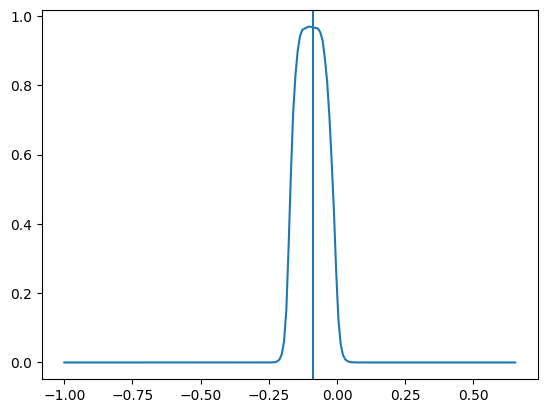

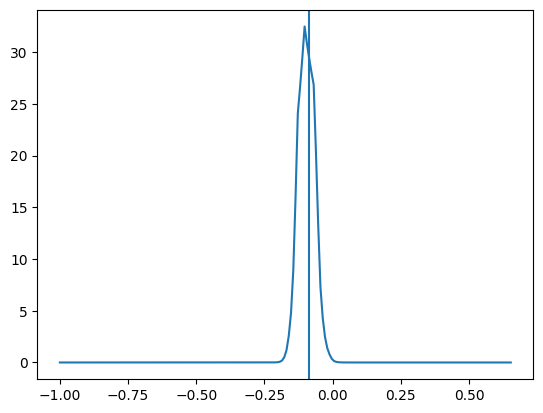

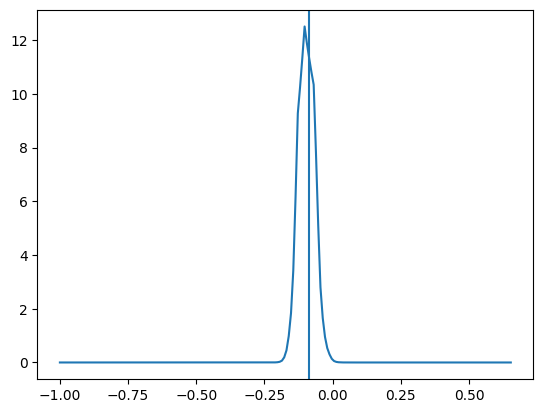

In [30]:
# different steps and their effect
iS = 42
print(malp[iS])

X = np.hstack((mrange.reshape(-1,1), np.array([x0[iS],]*len(mrange))))
X = xzscaler.transform(X)
score = np.array(model(X))
LER = score/(1-score)

# classifier score
plt.plot(mrange, score)
plt.axvline(np.log10(malp[iS]))
plt.show()

# classifier likelihood evidence ratio
plt.plot(mrange, LER)
plt.axvline(np.log10(malp[iS]))
plt.show()

# normalized posterior
posts = postvals(mrange, model, iS)
plt.plot(mrange, posts)
plt.axvline(np.log10(malp[iS]))
plt.show()

In [31]:
# can give issues in the case of multimodal posteriors
# computes confidence level
ibin = np.digitize(np.log10(malp[iS]), mrange)
posts = postvals(mrange, model, iS)
clevel = trapezoid(posts[posts>(posts[ibin-1]+posts[ibin])/2], mrange.reshape(-1,1)[posts>(posts[ibin-1]+posts[ibin])/2])
print(clevel)

0.10135720655092481


#### network evaluation (whole parameter space)

Takes around one minute, geometry and smearing fixed above

In [32]:
dirfolder = "../models/model_post_"+labsm+"_0"
model0 = keras.models.load_model(dirfolder+"/model.tf")

In [33]:
# we just pick a file where to evaluate the posteriors
bkgfile = data_path+"event_bkg_13_"+par_lab+geo_lab+".csv"

np.random.seed(42)
feats=feature_extract(bkgfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1,  x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
x0 = feats.extract_llo(0).T
malp, _ = feats.extract_model(0)
nlin = 200 # number of grid points
xzscaler = pickle.load(open(dirfolder+'/xzscaler.pkl', 'rb'))
mrange = np.linspace(np.log10(malp_min), np.log10(malp_max), nlin) # no point in extending beyond the range due to the prior

/home/alessandro/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [34]:
# we also save the performances so that we can use them later and put them in the same figure
perf0 = []
for iS in range(10000):
    posts = postvals(mrange, model0, iS)
    sig = np.sqrt(trapezoid((mrange**2)*posts.T, mrange.reshape(1,-1))-trapezoid(mrange*posts.T, mrange.reshape(1,-1))**2)
    meanmass = trapezoid(mrange*posts.T, mrange.reshape(1,-1))
    ibin = np.digitize(np.log10(malp[iS]), mrange)
    clevel = trapezoid(posts[posts>(posts[ibin-1]+posts[ibin])/2], mrange.reshape(-1,1)[posts>(posts[ibin-1]+posts[ibin])/2])
    perf0.append([sig[0], meanmass[0], clevel])
perf0= np.array(perf0)
# np.save("performances/"+subfolder_lab+"posterior_dist_"+labsm, perf0)

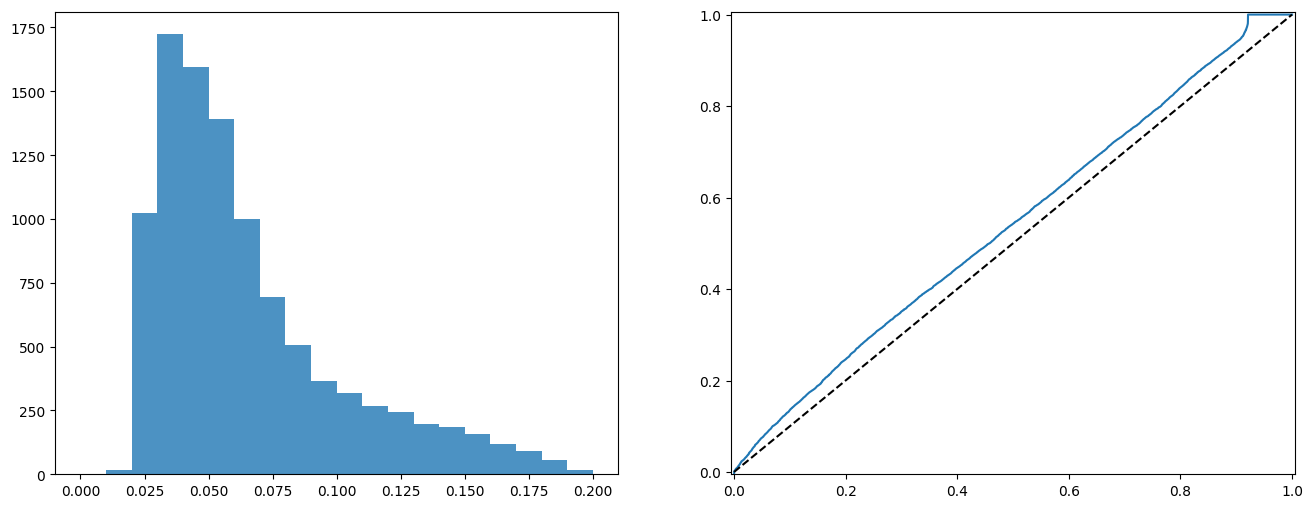

In [35]:
fig, axs = plt.subplots(ncols =2, figsize = (16, 6))

axs[0].hist(perf0[:,0], alpha =0.8, range = [0, 0.2], bins =20)


axs[1].plot(np.linspace(0,1, 10000), np.sort(1-perf0[:,2]))
axs[1].plot(np.linspace(0,1, 10000), np.linspace(0,1, 10000), color='black', linestyle='--')
axs[1].set_xlim(-0.005, 1.005)
axs[1].set_ylim(-0.005, 1.005)
plt.show()


#### Figure with different geometries and smearing together

Performances are actually evaluated in the previous step

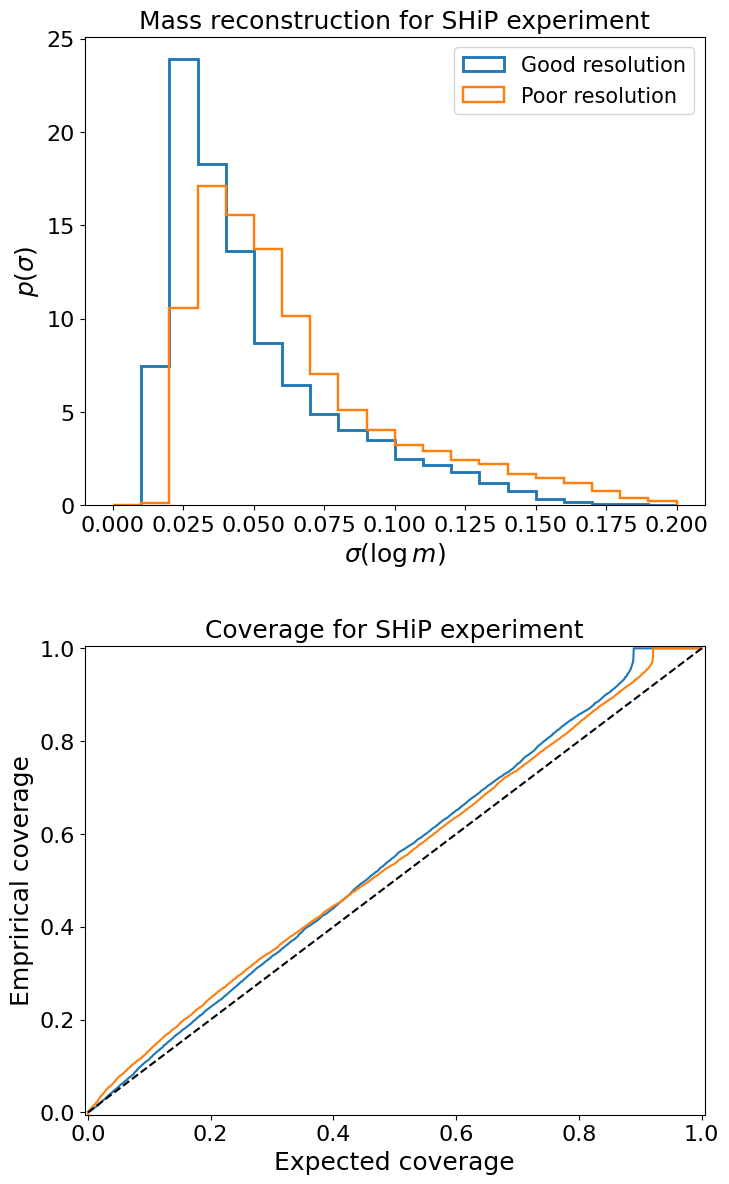

In [36]:
perf0, perf1 = np.load("../performances/coverage/posterior_dist_small.npy"), np.load("../performances/coverage/posterior_dist_large.npy")


fig, axs = plt.subplots(nrows =2, figsize = (figwidth/2, 14), gridspec_kw={"hspace": 0.3})

axs[0].hist(perf0[:,0], alpha = 1, range = [0., 0.2], bins =20, density=True, label="Good resolution", histtype='step', linewidth=2.05)
axs[0].hist(perf1[:,0], alpha = 1, range = [0., 0.2], bins =20, density=True, label="Poor resolution", histtype='step', linewidth=1.75)
axs[0].set_xlabel(r"$\sigma(\log m)$", fontsize=la_size)
axs[0].set_ylabel(r"$p(\sigma)$", fontsize=la_size)
# axs[0].axvline(np.mean(perf0[:,0]), color ='C0')


axs[1].plot(np.linspace(0,1, 10000), np.sort(1-perf0[:,2]))
axs[1].plot(np.linspace(0,1, 10000), np.sort(1-perf1[:,2]))
axs[1].plot(np.linspace(0,1, 10000), np.linspace(0,1, 10000), color='black', linestyle='--')
axs[1].set_xlim(-0.005, 1.005)
axs[1].set_ylim(-0.005, 1.005)
axs[1].set_xlabel("Expected coverage", fontsize=la_size)
axs[1].set_ylabel("Emprirical coverage", fontsize=la_size)

for _ in range(2):
    axs[_].tick_params(axis='both', which='major', labelsize=majt_size)
    axs[_].tick_params(axis='both', which='minor', labelsize=mint_size)

axs[0].legend(fontsize=le_size)
axs[0].set_title("Mass reconstruction for SHiP experiment", fontsize=ti_size)
axs[1].set_title("Coverage for SHiP experiment", fontsize=ti_size)

# plt.savefig("../figures/post_reco_geo_SHiP.pdf", bbox_inches='tight')
plt.show()


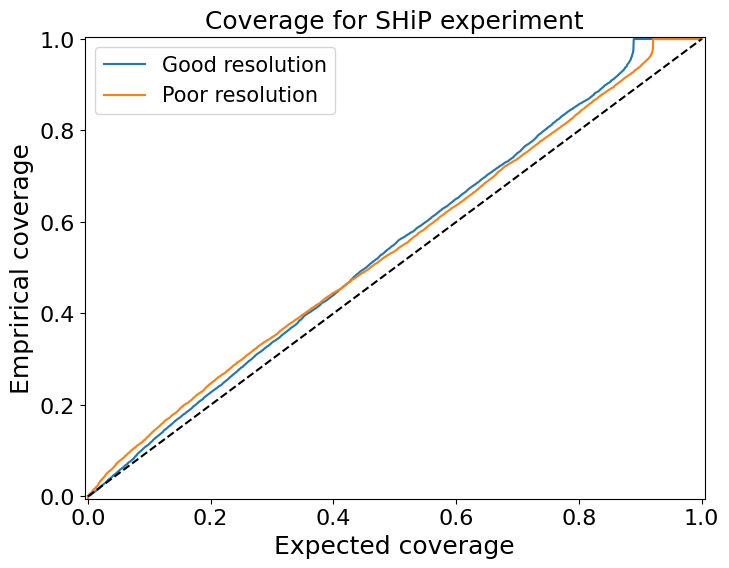

In [37]:
perf0, perf1 = np.load("../performances/coverage/posterior_dist_small.npy"), np.load("../performances/coverage/posterior_dist_large.npy")


fig, axs = plt.subplots(nrows =1, figsize = (figwidth/2, 6), gridspec_kw={"hspace": 0.3})

axs.plot(np.linspace(0,1, 10000), np.sort(1-perf0[:,2]), label="Good resolution")
axs.plot(np.linspace(0,1, 10000), np.sort(1-perf1[:,2]), label="Poor resolution")
axs.plot(np.linspace(0,1, 10000), np.linspace(0,1, 10000), color='black', linestyle='--')
axs.set_xlim(-0.005, 1.005)
axs.set_ylim(-0.005, 1.005)
axs.set_xlabel("Expected coverage", fontsize=la_size)
axs.set_ylabel("Emprirical coverage", fontsize=la_size)

axs.tick_params(axis='both', which='major', labelsize=majt_size)
axs.tick_params(axis='both', which='minor', labelsize=mint_size)

axs.legend(fontsize=le_size)
axs.set_title("Coverage for SHiP experiment", fontsize=ti_size)

# plt.savefig("../figures/coverage_SHiP.pdf", bbox_inches='tight')
plt.show()


### posterior export (actually performed by script extract_posterior in x/morandini, also in data folder)

Procedure is for bkg events:
```
- python3.10 extract_post.py --ifile 5/13 --Nlin 200 --Nsam 10000 --icol $SLURM_ARRAY_TASK_ID  --smear 0/1 --ship 1
- python3.10 merge_post.py --ifile 5/13 --smear 0/1 --ship 1 
```
Procedure is for sig events:
```
- python3.10 extract_post.py --ifile 8 --Nlin 200 --Nsam 10000 --icol $SLURM_ARRAY_TASK_ID  --smear 0/1 --ship 1 --mfixed 0.2/1.0/4.0
- python3.10 merge_post.py --ifile 8 --smear 0/1 --ship 1 --mfixed 0.2/1.0/4.0
```
Procedure is for training events:
```
- python3.10 extract_post.py --ifile 0/1 --Nlin 200 --Nsam 250000 --icol $SLURM_ARRAY_TASK_ID  --smear 0/1 --ship 1
- python3.10 merge_post.py --ifile 0/1 --smear 0/1 --ship 1 
```

## EPO hunt(ROC)

We take the previously trained classifier and apply it to a case with fixed number of bkg and sig events

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

In [39]:
smear = 1
if smear == 0:
    sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small uncertainty case
elif smear == 1:
    sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large" # large uncertainty case

In [40]:
dirfolder = "../models/model_post_01_"+labsm+"_0"
# model = keras.models.load_model(dirfolder+"/model.keras")
model = keras.models.load_model(dirfolder+"/model.tf")


In [41]:
with open(dirfolder+'/meta_par.pkl', 'rb') as file_t:
   meta_par = pickle.load(file_t)

#### ROC curve

2024-07-30 14:52:14.547295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
/tmp/ipykernel_36932/4051647992.py:46: RuntimeWarning: divide by zero encountered in divide
  axs.plot(tpr, 1/fpr, label = r"$m_a=$"+"{:.1f}GeV, AUC={:.2f}".format(mfixed, roc_auc_score(y, scores)), color=color_list[icol], linewidth = 1.5, linestyle='--')


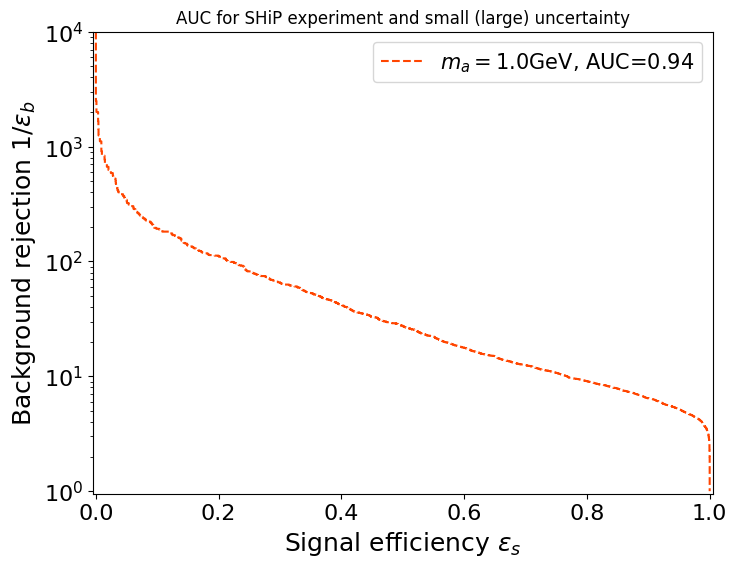

In [42]:
# here we consider only smear =1 and mfixed =1. as it is the only case provided in the repository by default
fig, axs = plt.subplots(figsize = (8, 6))

efficiencies = [] 
for smear in [1]: # only large here by default
    if smear ==0:
        sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small smearing case
    elif smear == 1:
        sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large"



    dirfolder = "../models/model_post_01_"+labsm+"_0"
    model = keras.models.load_model(dirfolder+"/model.tf")
    with open(dirfolder+'/meta_par.pkl', 'rb') as file_t:
        meta_par = pickle.load(file_t)

    for icol, mfixed in enumerate([1.]): # only m =1 GeV by default
        # seed already fixed at the extraction of the posterior
        sigfile = data_path + "post_sig_8_"+labsm+"_m_"+str(mfixed)+".csv"
        bkgfile = data_path + "post_bkg_13_"+labsm+".csv"

        feats = post_extract(bkgfile)
        x0= feats.extract_post(2)
        del feats

        feats = post_extract(sigfile)
        x1= feats.extract_post(2)
        del feats

        x0 = x0.reshape(10000,2,200)
        x1 = x1.reshape(10000,2,200)

        X = reg_log(np.vstack((x0,x1)), meta_par["pref"])
        y=np.hstack((np.zeros(len(x0)),np.ones(len(x1))))


        del x0, x1

        scores = np.array(model(X)).flatten()

        fpr, tpr, _ = roc_curve(y, scores)
        if smear == 0:
            axs.plot(tpr, 1/fpr, label = r"$m_a=$"+"{:.1f}GeV, AUC={:.2f}".format(mfixed, roc_auc_score(y, scores)), color=color_list[icol], linewidth = 1.5)
        elif smear == 1:
            axs.plot(tpr, 1/fpr, label = r"$m_a=$"+"{:.1f}GeV, AUC={:.2f}".format(mfixed, roc_auc_score(y, scores)), color=color_list[icol], linewidth = 1.5, linestyle='--')
        efficiencies.append([smear, mfixed, tpr[fpr>0.1][0],tpr[fpr>0.01][0], 1/fpr[tpr>0.8][0], 1/fpr[tpr>0.9][0]])
        # np.savetxt("../performances/roc/fprtpr_cl_post_"+labsm+"_m_"+str(mfixed)+".csv", np.vstack((fpr, tpr)))


axs.legend(fontsize=le_size)
axs.set_xlabel(r"Signal efficiency $\epsilon_s$", fontsize=la_size)
axs.set_ylabel(r"Background rejection $1/\epsilon_b$", fontsize=la_size)
axs.set_title("AUC for SHiP experiment and small (large) uncertainty")
axs.set_xlim(-0.005,1.005)
axs.set_ylim(0.95,10**4)
axs.set_yscale('log')

axs.tick_params(axis='both', which='major', labelsize=majt_size)
axs.tick_params(axis='both', which='minor', labelsize=mint_size)
#np.savetxt("../performances/roc/roc_efficiencies_post.csv", np.array(efficiencies))

#plt.savefig("figures/rocv2_post_geo_"+str(iSHIP)+".pdf", bbox_inches='tight')
plt.show()

Now we export separately for the different models

In [43]:
for imodel in range(5):
    efficiencies = []
    for smear in [1]: # only poor resolution here
        if smear ==0:
            sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small smearing case
        elif smear == 1:
            sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large"

        dirfolder ="../models/model_post_01_"+labsm+"_"+str(imodel)
        model = keras.models.load_model(dirfolder+"/model.tf")

        for mfixed in [1.]: # fixed only to 1GeV here
            sigfile = data_path + "post_sig_8_"+labsm+"_m_"+str(mfixed)+".csv"
            bkgfile = data_path + "post_bkg_13_"+labsm+".csv"

            feats = post_extract(bkgfile)
            x0= feats.extract_post(2)
            del feats

            feats = post_extract(sigfile)
            x1= feats.extract_post(2)
            del feats

            x0 = x0.reshape(10000,2,200)
            x1 = x1.reshape(10000,2,200)

            X = reg_log(np.vstack((x0,x1)), meta_par["pref"])
            y=np.hstack((np.zeros(len(x0)),np.ones(len(x1))))


            del x0, x1

            scores = np.array(model(X)).flatten()

            fpr, tpr, thr_list = roc_curve(y, scores)
            efficiencies.append([smear, mfixed, tpr[fpr>0.1][0],tpr[fpr>0.01][0], 1/fpr[tpr>0.8][0], 1/fpr[tpr>0.9][0], roc_auc_score(y, scores)])
            #np.savetxt("../performances/roc/fprtpr_cl_post_"+labsm+"_m_"+str(mfixed)+"_model"+str(imodel)+".csv", np.vstack((fpr, tpr, thr_list)).T)
        #np.savetxt("../performances/roc/roc_efficiencies_post_model"+str(imodel)+".csv", np.array(efficiencies))